# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\zbro1\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [113]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,self_installed,tilt_1,additional_modules,bipv_module_1,efficiency_module_1,inverter_quantity_1,...,inverter_model_1_IQ6PLUS-72-ACM-US [240V],inverter_model_1_SE3800H-US (240V),inverter_model_1_SE9KUS [208V],inverter_model_1_IQ7XS-96-E-ACM-US [240V],inverter_model_1_SE7600H-US (240V),inverter_model_1_SPR-X22-360-E-AC [208V],inverter_model_1_SE11400H-US (240V),inverter_model_1_IQ7-60-x-ACM-US [208V],inverter_model_1_SE10000H-US (240V),inverter_model_1_SB3.8-1SP-US-40 [208V]
351828,5.120,0.0,0,0.0,0.0,26.0,0.0,0.0,0.197531,16.0,...,0,0,0,0,0,0,0,0,0,0
391690,5.520,0.0,0,0.0,0.0,23.0,0.0,0.0,0.209255,16.0,...,0,0,0,0,0,0,0,0,0,0
397978,13.545,0.0,0,0.0,0.0,19.0,0.0,0.0,0.194085,43.0,...,0,0,0,0,0,0,0,0,0,0
455364,3.150,0.0,0,1.0,0.0,18.0,0.0,0.0,0.194444,1.0,...,0,0,0,0,0,0,0,0,0,0
382648,8.640,0.0,0,0.0,0.0,30.0,0.0,0.0,0.198895,24.0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
X_train.shape, y_train.shape

((156192, 400), (156192, 1))

In [12]:
X_train.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US [240V]',
       'inverter_model_1_SE3800H-US (240V)', 'inverter_model_1_SE9KUS [208V]',
       'inverter_model_1_IQ7XS-96-E-ACM-US [240V]',
       'inverter_model_1_SE7600H-US (240V)',
       'inverter_model_1_SPR-X22-360-E-AC [208V]',
       'inverter_model_1_SE11400H-US (240V)',
       'inverter_model_1_IQ7-60-x-ACM-US [208V]',
       'inverter_model_1_SE10000H-US (240V)',
       'inverter_model_1_SB3.8-1SP-US-40 [208V]'],
      dtype='object', length=400)

Before I begin I'm going to calculate RMSE values for different train-test split ratios using ridge regression and a fixed alpha parameter so that I can train the models on the smallest amount of train data possible. I'm having extremely long training times if I default to 80% train 20% test, so any shift I can do will help.

In [30]:
split_ratios = {}

ratios = [0.1, 0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8]

for ratio in ratios:
    x_train, x_test, y_trn, y_test = train_test_split(X_train, y_train, test_size = ratio)
    y_trn = y_trn.values.ravel()
    y_test = y_test.values.ravel()
    
    ridge = Ridge(alpha = 100,random_state = 12)
    ridge.fit(x_train, y_trn)
    y_pred = ridge.predict(x_test)
    
    split_ratios[ratio] = mean_squared_error(y_test, y_pred)

In [31]:
split_ratios

{0.1: 3207101.201080334,
 0.2: 141270898.407688,
 0.25: 2544550.0262977174,
 0.3: 7360116.440779946,
 0.4: 9353374.206263728,
 0.45: 14974482.454158897,
 0.5: 58579025.245523825,
 0.55: 62737759.129215576,
 0.6: 2934498.4372942266,
 0.7: 48113757.58380508,
 0.8: 5641551.146836105}

In [32]:
splits = pd.DataFrame(data = split_ratios, index=['RMSE']).T
splits

,RMSE
0.10,3.207101e+06
0.20,1.412709e+08
0.25,2.544550e+06
0.30,7.360116e+06
0.40,9.353374e+06
0.45,1.497448e+07
0.50,5.857903e+07
0.55,6.273776e+07
0.60,2.934498e+06
0.70,4.811376e+07


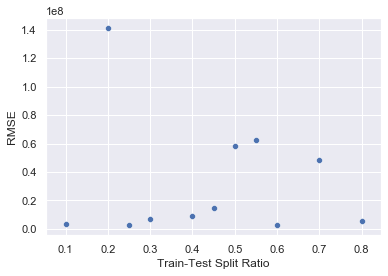

In [34]:
sns.scatterplot(data = splits, x=splits.index, y=splits['RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Train-Test Split Ratio')
plt.show()

There's a lot of randomness I didn't expect to see here, but it looks like below a ratio of 0.5 I'm likely to get a good RMSE, so I'll set it to 0.45 for my modeling. This also suggests to me that there are some outliers that are critical to achieving a good fit.

In [115]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.45)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((85905, 400), (70287, 400), (85905, 1), (70287, 1))

In [116]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. I'm going to score my models based on root mean squared error (RMSE) to make sure that I'm holding them accountable for hitting outliers accurately.

In [117]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_squared_error(y_te, y_pred)}
print(mean_squared_error(y_te, y_pred))

5239123.359227423


In [118]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

5265953.656897985


In [119]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

5963284.520518316


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [120]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

4918162.654417593


OLS produces a minor improvement over the dummy regressors. That said, the RMSE is massive and I suspect that there are a few outliers driving the error. I'll plot predicted vs actual to quickly visualize if there are a few specific outliers that need to be dropped.

[]

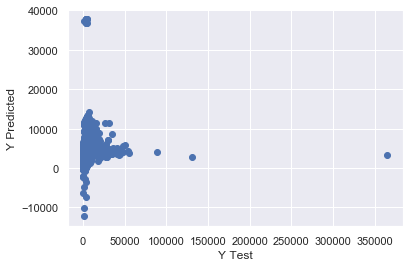

In [121]:
plt.plot(y_te, y_pred, marker='o', linestyle='')
plt.xlabel('Y Test')
plt.ylabel('Y Predicted')
plt.plot()

It looks like there are three points that are extreme outliers. I'll remove them and rerun the OLS model.

y_diff = y_pred - y_te
outliers = abs(y_diff) > 100000
outlier_indices = [i for i, x in enumerate(outliers) if x]
outlier_indices

x_te = x_te.reset_index().drop(labels=outlier_indices, axis=0)
y_te = np.delete(y_te, outliers)
x_te.shape, y_te.shape

 Now I'll take a look at ridge regression to see if it will generate a better model.

In [122]:
parameters = {'alpha': sp_randFloat(2,100)}
ridge = Ridge(random_state = 12)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 100.4596725217403}

In [123]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

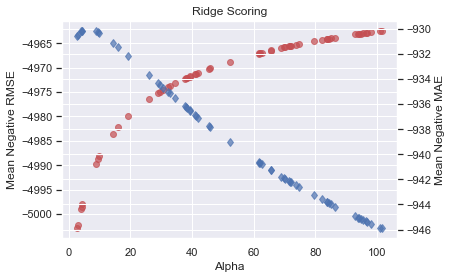

In [43]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
plt.title('Ridge Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [44]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 12)
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

12743311.184466548


So ridge regression performs slightly better than OLS, good to know. Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [45]:
parameters = {'alpha': sp_randFloat(1,100)}
lasso = linear_model.Lasso(random_state = 12)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 22.03825610738409}

In [46]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.534988,0.015852,0.032314,0.002932,55.88135,{'alpha': 55.88135039273247},-15804.795888,-3949.514728,-1943.603529,-1606.000015,...,5450.941474,31,-1164.031257,-1068.041308,-1049.847247,-1030.528973,-1035.131091,-1069.515975,49.039736,31
1,0.502855,0.008951,0.031317,0.003128,72.518937,{'alpha': 72.51893663724195},-15805.603276,-3953.143855,-1951.598681,-1615.302117,...,5448.006117,46,-1175.581117,-1078.275082,-1059.513047,-1039.655040,-1044.987340,-1079.602325,49.822188,46
2,0.513227,0.019913,0.031717,0.002985,61.276338,{'alpha': 61.276337607164386},-15805.033469,-3950.747502,-1946.413651,-1609.483759,...,5449.858235,35,-1168.196568,-1071.834563,-1053.364003,-1034.012216,-1038.748368,-1073.231144,49.279350,35
3,0.527788,0.015261,0.034110,0.004522,55.488318,{'alpha': 55.48831829968969},-15804.779909,-3949.402268,-1943.325514,-1605.719853,...,5451.040041,30,-1163.735971,-1067.731462,-1049.504209,-1030.243711,-1034.803199,-1069.203710,49.046637,30
4,0.610966,0.056172,0.032114,0.003116,43.36548,{'alpha': 43.36547993389047},-15803.715860,-3944.242889,-1931.478690,-1593.222664,...,5455.146310,21,-1148.363307,-1053.229450,-1034.845484,-1017.829434,-1021.420586,-1055.137652,48.239361,21


C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002BC80046408> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002BC801FB708> has a label of '_line0' which cannot be automatically added to the legend.
  if sys.path[0] == '':


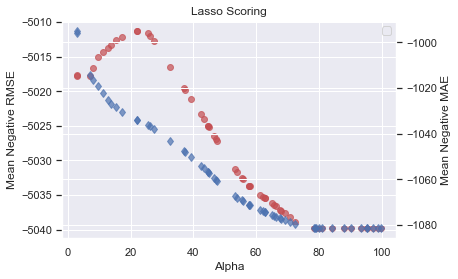

In [47]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

plt.title('Lasso Scoring')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [48]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 12)
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_squared_error(y_te, y_pred)
print(mean_squared_error(y_te, y_pred))

13006900.844240315


Lasso slots in right between ridge and OLS regression. Next I'm going to take a look at random forest and see if that can produce a significant reduction in RMSE.

In [49]:
parameters = {'max_features': sp_randFloat(0.35, 0.48),
             'max_depth': sp_randInt(6,12),
             'min_samples_leaf': sp_randInt(580,780),
             'n_estimators': sp_randInt(900,1100)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 9,
 'max_features': 0.3569959819930014,
 'min_samples_leaf': 602,
 'n_estimators': 949}

In [50]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_n_estimators', 'params',
       'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

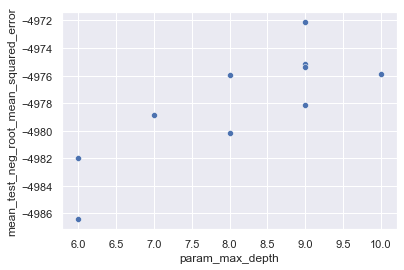

In [51]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_root_mean_squared_error')
plt.show()

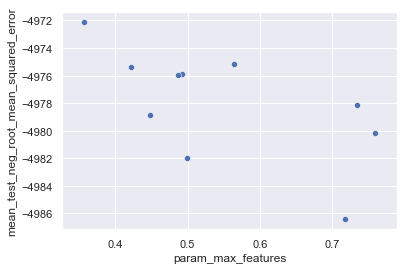

In [52]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_root_mean_squared_error')
plt.show()

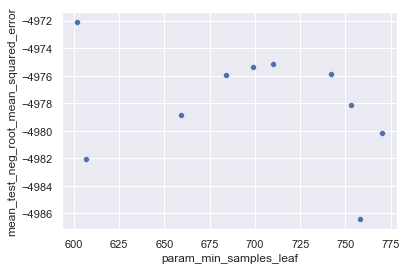

In [53]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_root_mean_squared_error')
plt.show()

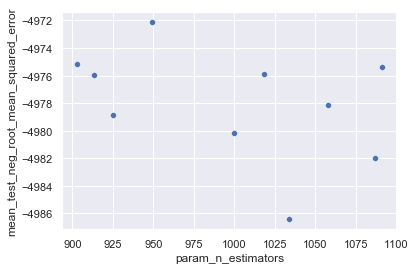

In [54]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_root_mean_squared_error')
plt.show()

In [55]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12817781.680527695

Nice, random forest improved upon the other models very significantly. I'll take a look at XGBoost next to see if it can improve even further.

In [56]:
x_tr.columns = x_tr.columns.str.replace('[', '_')
x_tr.columns = x_tr.columns.str.replace(']', '_')
x_tr.columns = x_tr.columns.str.replace(' ', '_')
x_tr.columns = x_tr.columns.str.replace(',', '_')
x_te.columns = x_te.columns.str.replace('[', '_')
x_te.columns = x_te.columns.str.replace(']', '_')
x_te.columns = x_te.columns.str.replace(' ', '_')
x_te.columns = x_te.columns.str.replace(',', '_')

C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
C:\Users\zbro1\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True

In [57]:
x_tr.columns

Index(['system_size_dc', 'rebate_or_grant', 'expansion_system',
       'third_party_owned', 'self_installed', 'tilt_1', 'additional_modules',
       'bipv_module_1', 'efficiency_module_1', 'inverter_quantity_1',
       ...
       'inverter_model_1_IQ6PLUS-72-ACM-US__240V_',
       'inverter_model_1_SE3800H-US_(240V)', 'inverter_model_1_SE9KUS__208V_',
       'inverter_model_1_IQ7XS-96-E-ACM-US__240V_',
       'inverter_model_1_SE7600H-US_(240V)',
       'inverter_model_1_SPR-X22-360-E-AC__208V_',
       'inverter_model_1_SE11400H-US_(240V)',
       'inverter_model_1_IQ7-60-x-ACM-US__208V_',
       'inverter_model_1_SE10000H-US_(240V)',
       'inverter_model_1_SB3.8-1SP-US-40__208V_'],
      dtype='object', length=400)

In [58]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=15)
xgbooster = rand_xgb.fit(x_tr, y_tr)
xgbooster.best_params_

{'colsample_bytree': 0.2184450768322397,
 'eta': 0.165670601141881,
 'max_depth': 2,
 'n_estimators': 870}

In [59]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

14067801.788099946

In [60]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

{'max_depth': 4, 'min_samples_leaf': 308}

In [61]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 12)
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12945942.518954603

Interesting, even a basic decision tree outperformed the random forest and lasso regressors. Let's keep testing a few additional models to determine which should be tuned further and used as the final model.

In [62]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

{'n_neighbors': 36}

In [63]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

13043709.918581616

In [64]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgbm.fit(x_tr, y_tr)
opt_lgbm.best_params_

{'learning_rate': 0.0069093558684842895,
 'max_depth': 4,
 'n_estimators': 852,
 'num_leaves': 106}

In [65]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

13740642.84340558

Now that I've done a quick once-over for these different models and identified XGBoost as the best fit for this challenge, I'm going to revisit XGBoost and see if I can't refine it further to improve the results even more.

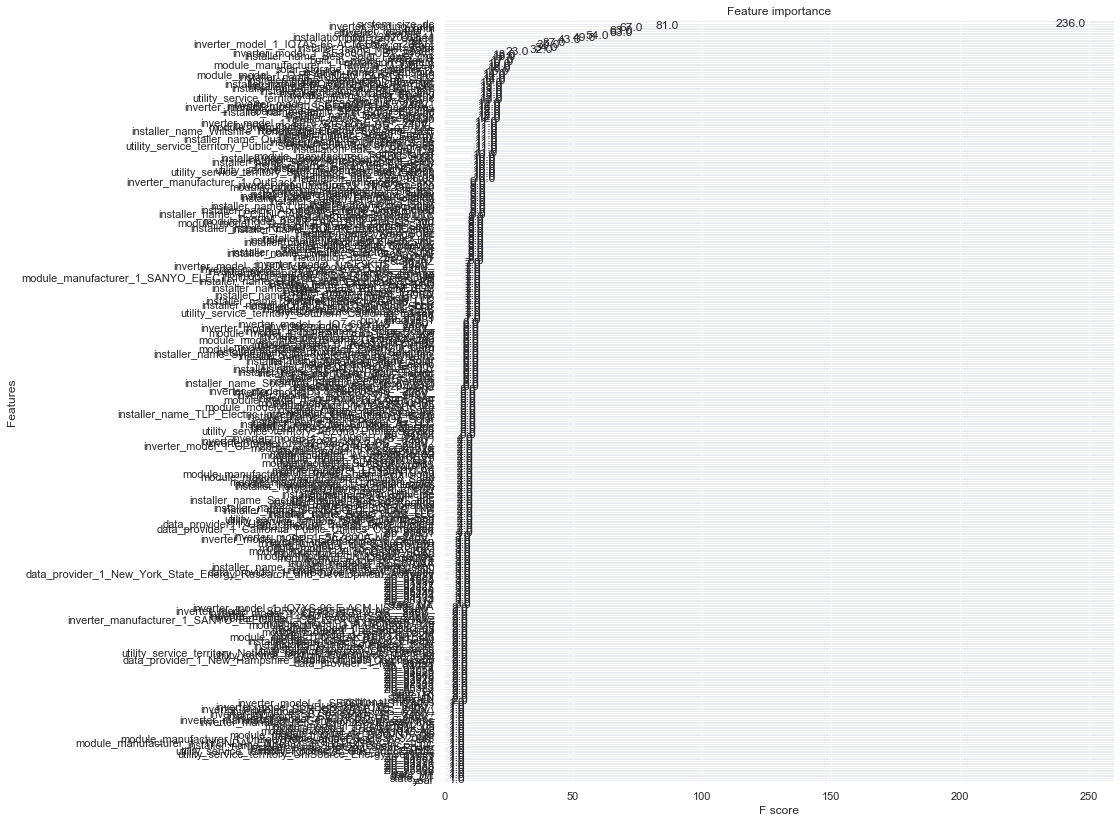

In [66]:
fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model, ax=ax)

# Previous best parameters
# 'colsample_bytree': 0.9887415865233958,
# 'eta': 0.3412489908771189,
# 'max_depth': 9,
# 'n_estimators': 859

xgb_2 = XGBRegressor(verbosity = 0)
parameters = {'n_estimators': sp_randInt(759,959),
             'max_depth': sp_randInt(7,11),
             'eta': sp_randFloat(0.14,0.54),
             'colsample_bytree': sp_randFloat(0.9,1)} 
rand_xgb_2 = RandomizedSearchCV(xgb_2, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
xgbooster_2 = rand_xgb_2.fit(x_tr, y_tr)
xgbooster_2.best_params_

xgb_model_2 = XGBRegressor(n_estimators=xgbooster_2.best_params_['n_estimators'],\
                                   eta=xgbooster_2.best_params_['eta'],\
                                   colsample_bytree=xgbooster_2.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster_2.best_params_['max_depth'])
xgb_model_2.fit(x_tr, y_tr)
y_pred = xgb_model_2.predict(x_te)
train_scores['XGBoost 2'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

fig, ax = plt.subplots(1,1,figsize=(12, 14))
xgboost.plot_importance(xgb_model_2, ax=ax)

In [67]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'cyclic',
 'reg_alpha': 0.5337393933802977,
 'reg_lambda': 0.014574962485419674}

In [68]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12818250.525441453

In [69]:
xgb_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
xgbooster_linear = rand_xgb_linear.fit(x_tr, y_tr)
xgbooster_linear.best_params_

{'feature_selector': 'random',
 'reg_alpha': 0.3504782760049925,
 'reg_lambda': 0.03396417126592133}

In [70]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(x_tr, y_tr)
y_pred = xgb_model_linear.predict(x_te)
train_scores['XGBoost Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12860323.54358546

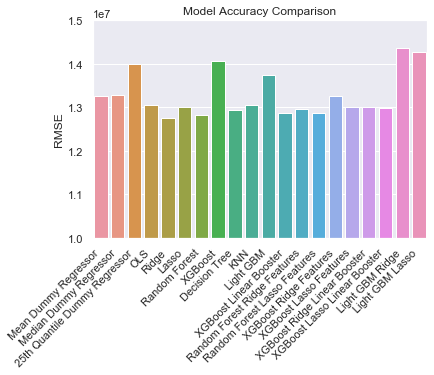

In [92]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(10000000,15000000)
plt.show()

In [72]:
print(np.quantile(y_train['price_per_kw'], 0.05))
print(np.quantile(y_train['price_per_kw'], 0.95))

1948.0855220799876
6077.570712746305


In [73]:
from sklearn.feature_selection import SelectFromModel

In [74]:
sel_ = SelectFromModel(ridge, prefit=True)
features = sel_.get_support()
x_tr_ridge = x_tr.iloc[:,features]
x_te_ridge = x_te.iloc[:,features]
x_tr_ridge.head()

,expansion_system,third_party_owned,self_installed,bipv_module_1,solar_storage_hybrid_inverter_1,state_CO,zip_85248,zip_94941,zip_95409,zip_93561,...,inverter_model_1_IQ7XS-96-y-ACM-z__240V_,inverter_model_1_SB5.0-1SP-US-40__208V_,inverter_model_1_IQ7AS-66-ACM-US-x__208V_,inverter_model_1_SOLIVIA_5.2_NA_G4_TL__240V_,inverter_model_1_SE3800H-US_(240V),inverter_model_1_SE9KUS__208V_,inverter_model_1_IQ7XS-96-E-ACM-US__240V_,inverter_model_1_SE7600H-US_(240V),inverter_model_1_IQ7-60-x-ACM-US__208V_,inverter_model_1_SB3.8-1SP-US-40__208V_
418016,1,1.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1432603,0,0.0,0.0,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502614,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1981735,0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391568,0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
sel_2 = SelectFromModel(lasso, prefit=True)
features = sel_2.get_support()
x_tr_lasso = x_tr.iloc[:,features]
x_te_lasso = x_te.iloc[:,features]
x_tr_lasso.head()

,system_size_dc,rebate_or_grant,expansion_system,third_party_owned,tilt_1,inverter_quantity_1,solar_storage_hybrid_inverter_1,built_in_meter_inverter_1,month,installation_date_2020-02-11,utility_service_territory_Pacific_Gas_and_Electric,installer_name_Vivint_Solar,module_manufacturer_1_Hanwha_Q_CELLS,module_manufacturer_1_SunPower,inverter_manufacturer_1_SunPower,inverter_model_1_SE3800H-US__240V_
418016,3.8808,0.0,1,1.0,2.0,1.0,0.0,1.0,6,0,1,1,0,0,0,1
1432603,7.5600,0.0,0,0.0,18.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0
502614,12.5000,0.0,0,0.0,23.0,50.0,0.0,0.0,2,0,1,0,1,0,0,0
1981735,4.5650,2500.0,0,0.0,18.0,11.0,0.0,0.0,12,0,0,0,0,1,1,0
391568,4.5500,0.0,0,1.0,23.0,1.0,0.0,1.0,8,0,0,0,1,0,0,0


In [76]:
parameters = {'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
r_forest = RandomForestRegressor(n_jobs=-1, random_state=12)
r_forest_reg = RandomizedSearchCV(r_forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
ridge_forest = r_forest_reg.fit(x_tr_ridge, y_tr)
opt_ridge_forest = RandomForestRegressor(n_estimators=ridge_forest.best_params_['n_estimators'],\
                                   max_features=ridge_forest.best_params_['max_features'],\
                                   min_samples_leaf=ridge_forest.best_params_['min_samples_leaf'],\
                                   max_depth=ridge_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_ridge_forest.fit(x_tr_ridge, y_tr)
y_pred = opt_ridge_forest.predict(x_te_ridge)
train_scores['Random Forest Ridge Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12968341.221104486

In [77]:
parameters = {'max_features': sp_randFloat(0.01, 1),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1,2000),
             'n_estimators': sp_randInt(800,1100)
             }
l_forest = RandomForestRegressor(n_jobs=-1, random_state=12)
l_forest_reg = RandomizedSearchCV(l_forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
lasso_forest = l_forest_reg.fit(x_tr_lasso, y_tr)
opt_lasso_forest = RandomForestRegressor(n_estimators=lasso_forest.best_params_['n_estimators'],\
                                   max_features=lasso_forest.best_params_['max_features'],\
                                   min_samples_leaf=lasso_forest.best_params_['min_samples_leaf'],\
                                   max_depth=lasso_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_lasso_forest.fit(x_tr_lasso, y_tr)
y_pred = opt_lasso_forest.predict(x_te_lasso)
train_scores['Random Forest Lasso Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12858312.6212125

In [78]:
r_xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
ridge_xgb = RandomizedSearchCV(r_xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=15)
r_xgbooster = ridge_xgb.fit(x_tr_ridge, y_tr)
r_xgb_model = XGBRegressor(n_estimators=r_xgbooster.best_params_['n_estimators'],\
                                   eta=r_xgbooster.best_params_['eta'],\
                                   colsample_bytree=r_xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=r_xgbooster.best_params_['max_depth'])
r_xgb_model.fit(x_tr_ridge, y_tr)
y_pred = r_xgb_model.predict(x_te_ridge)
train_scores['XGBoost Ridge Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

13249410.179741744

In [79]:
l_xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
lasso_xgb = RandomizedSearchCV(l_xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=15)
l_xgbooster = lasso_xgb.fit(x_tr_lasso, y_tr)
l_xgb_model = XGBRegressor(n_estimators=l_xgbooster.best_params_['n_estimators'],\
                                   eta=l_xgbooster.best_params_['eta'],\
                                   colsample_bytree=l_xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=l_xgbooster.best_params_['max_depth'])
l_xgb_model.fit(x_tr_lasso, y_tr)
y_pred = l_xgb_model.predict(x_te_lasso)
train_scores['XGBoost Lasso Features'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

13016953.829953609

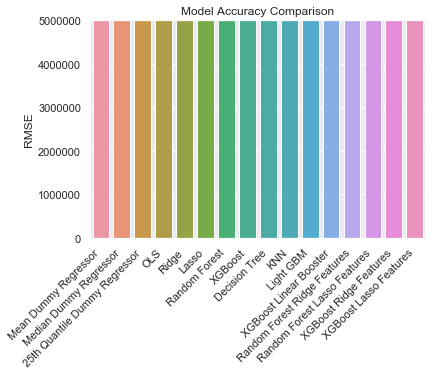

In [80]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(0,5000000)
plt.show()

In [81]:
xgb_r_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
ridge_xgb_linear = RandomizedSearchCV(xgb_r_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
xgbooster_ridge_linear = ridge_xgb_linear.fit(x_tr_ridge, y_tr)
xgb_ridge_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_ridge_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_ridge_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_ridge_linear.best_params_['feature_selector'])
xgb_ridge_linear.fit(x_tr_ridge, y_tr)
y_pred = xgb_ridge_linear.predict(x_te_ridge)
train_scores['XGBoost Ridge Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

13016040.055730287

In [82]:
xgb_l_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
lasso_xgb_linear = RandomizedSearchCV(xgb_l_linear, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
xgbooster_lasso_linear = lasso_xgb_linear.fit(x_tr_lasso, y_tr)
xgb_lasso_linear = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_lasso_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_lasso_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_lasso_linear.best_params_['feature_selector'])
xgb_lasso_linear.fit(x_tr_lasso, y_tr)
y_pred = xgb_lasso_linear.predict(x_te_lasso)
train_scores['XGBoost Lasso Linear Booster'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

12979121.189736387

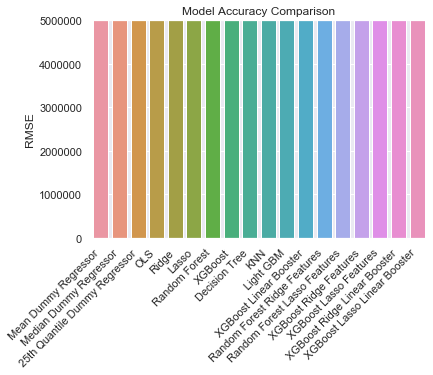

In [83]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Model Accuracy Comparison')
plt.ylim(0,5000000)
plt.show()

In [84]:
r_lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
ridge_lgbm = RandomizedSearchCV(r_lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
opt_ridge_lgbm = ridge_lgbm.fit(x_tr_ridge, y_tr)
lgbm_r_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_ridge_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_ridge_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_ridge_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_ridge_lgbm.best_params_['learning_rate'])
lgbm_r_opt.fit(x_tr_ridge, y_tr)
y_pred = lgbm_r_opt.predict(x_te_ridge)
train_scores['Light GBM Ridge'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

14368801.694061397

In [85]:
l_lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
lasso_lgbm = RandomizedSearchCV(l_lgbm, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=12)
opt_lasso_lgbm = lasso_lgbm.fit(x_tr_lasso, y_tr)
lgbm_l_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lasso_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lasso_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lasso_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lasso_lgbm.best_params_['learning_rate'])
lgbm_l_opt.fit(x_tr_lasso, y_tr)
y_pred = lgbm_l_opt.predict(x_te_lasso)
train_scores['Light GBM Lasso'] = mean_squared_error(y_te, y_pred)
mean_squared_error(y_te, y_pred)

14270412.223932542

In [86]:
importances = pd.concat([pd.Series(xgb_model_linear.feature_importances_), pd.Series(opt_forest.feature_importances_),\
                       pd.Series(decision_tree_model.feature_importances_), pd.Series(lgbm_opt.feature_importances_)],\
                         keys = x_tr.columns) 
importances.head()

system_size_dc  0   -0.004478
                1   -0.000054
                2    0.098844
                3   -0.116762
                4   -0.105362
dtype: float64

In [87]:
importances.head()

system_size_dc  0   -0.004478
                1   -0.000054
                2    0.098844
                3   -0.116762
                4   -0.105362
dtype: float64

In [88]:
rf_top_ten = list(zip(opt_forest.feature_importances_, x_tr.columns))
rf_top_ten.sort(reverse=True)
rf_top_ten = rf_top_ten[0:10]
xgbl_top_ten = list(zip(xgb_model_linear.feature_importances_, x_tr.columns))
xgbl_top_ten.sort(reverse=True)
xgbl_top_ten = xgbl_top_ten[0:10]
print(rf_top_ten)

[(0.2417541065247585, 'system_size_dc'), (0.14600250015628177, 'installer_name_Vivint_Solar'), (0.09450181843865883, 'third_party_owned'), (0.06849460051438136, 'rebate_or_grant'), (0.047326294476023274, 'solar_storage_hybrid_inverter_1'), (0.03695469024132039, 'efficiency_module_1'), (0.029323826405657692, 'month'), (0.026952913797634762, 'utility_service_territory_Public_Service_Company_of_Colorado'), (0.02303165794950713, 'inverter_manufacturer_1_SunPower'), (0.022405374057350012, 'state_CO')]


In [89]:
print(xgbl_top_ten)

[(0.22502153, 'installation_date_2020-02-11'), (0.2059061, 'installer_name_Vivint_Solar'), (0.14385656, 'solar_storage_hybrid_inverter_1'), (0.09884354, 'expansion_system'), (0.094511494, 'inverter_loading_ratio'), (0.09013274, 'installer_name_Infinity_Energy_Inc.'), (0.08167123, 'utility_service_territory_Consolidated_Edison'), (0.08057233, 'built_in_meter_inverter_1'), (0.07622452, 'state_CO'), (0.076157644, 'utility_service_territory_Public_Service_Company_of_Colorado')]


Up to this point I've worked entirely with a train-test split of 80%. I'm going to run my best model to this point - the XXXX model - with a series of different train-test split levels up to 95% to determine whether feeding it more data can significantly improve the results.